In [4]:
import matplotlib.pyplot as plt
import numpy as np

This function makes nice $\LaTeX$ labels for different final states

In [5]:
def get_tex_label(label):
    tex_label = r"$"+ label
    tex_label = tex_label.replace("pi0", "\pi^0")
    tex_label = tex_label.replace("pi pi", "\pi^+ \pi^-")
    tex_label = tex_label.replace("mu mu", "\mu^+ \mu^-")
    tex_label = tex_label.replace("g", "\gamma")
    tex_label = tex_label.replace("e e", "e^+ e^-")
    return tex_label + r"$"

These imports give access to COMPTEL's energy resolution and a function to convolve a spectrum with a detector's smearing function. We will use these to understand how lines contribute to the spectrum for this model.

In [176]:
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import energy_res_comptel
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum

# Vector mediator

This import loads the vector mediator class from hazma.

In [ ]:
from hazma.vector_mediator import VectorMediator

## Spectrum for benchmark parameters

First, initialize the vector mediator class. Since the couplings of $V$ to electrons and muons is arbitrary, we set them to zero so we can focus on photons coming from hadronic final states. We take $m_\chi = 250$ MeV, the upper bound of validity for this theory. The value of $m_V$ does not affect the spectra.

In [115]:
vm_args = {"mx": 175., "mv": 1000., "gvxx": 1., "gvuu": 1., "gvdd": 0.2, "gvss": 0., "gvee": 0., "gvmumu": 0.}
vm = VectorMediator(**vm_args)

Next, create an array with 500 logarithmically spaced values of $E_\gamma$ between 10 MeV and $m_\chi$.

In [116]:
e_gam_min, e_gam_max, n_e_gams = 10., vm.mx, 500
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

Now the fun part: pass this array to `spectra()`, which returns a dictionary giving each final state's contribution to the photon spectrum per annihilation. The dark matter needs a small velocity so the cross sections don't diverge, so we set $v_\chi = 10^{-3}$, the usual Milky Way velocity dispersion. Varying $v_\chi$ by an order of magnitude in either direction has little impact on the resulting spectra.

In [117]:
vx_mw = 1.0e-3

spectra = vm.spectra(e_gams, 2.*vm.mx * (1. + 0.5 * vx_mw))

Lastly, plot the results, dropping all final states without hadrons:

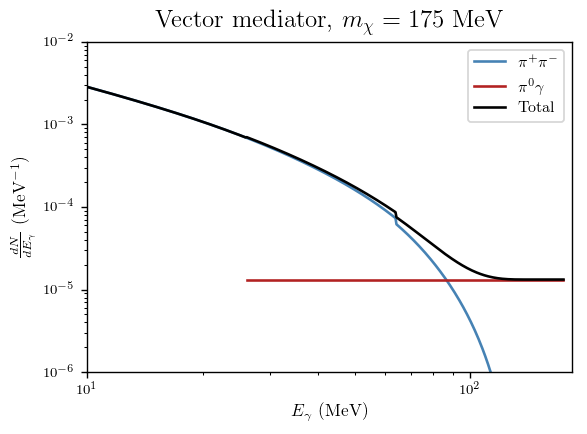

In [118]:
for fs, spec in sorted(spectra.iteritems()):
    if fs not in ["e e", "mu mu", "total"]:
        plt.loglog(e_gams, spec, label=get_tex_label(fs))
    if fs == "total":
        plt.loglog(e_gams, spec, "black", label="Total")

plt.title("Vector mediator, $m_\chi = %.0f$ MeV" % vm.mx)
plt.xlim(e_gams[0], 1.05 * e_gams[-1])
plt.ylim(1e-6, 1e-2)
plt.xlabel(r"$E_\gamma$ (MeV)")
plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
plt.legend()

## Spectra's dependence on $m_\chi$
This section examines the dependence of the spectra on the dark matter mass. The dependence on the couplings is less interesting since adjusting them just shifts the normalization of the different final states' contributions.

Create a `VectorMediator` object. The values of couplings to leptons and the strange quark and well as $m_V$ are irrelevant to our focus. The initial value of $m_\chi$ does not matter since it will shortly be changed. The velocity dispersion in the Milky Way $v_\chi \sim 10^{-3}$ is defined here, as it was above.

In [290]:
vm_args = {"mx": 250., "mv": 1000., "gvxx": 1., "gvuu": 1., "gvdd": 0.2, "gvss": 0., "gvee": 0., "gvmumu": 0.}
vm = VectorMediator(**vm_args)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

Choose a less dense array of photon energies from 10 - 250 MeV.

In [291]:
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250

e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

Create a 2D array of dark matter masses.

In [292]:
n_subplot_rows, n_subplot_cols = 1, 2

mxs = np.array([143., 200.]).reshape((n_subplot_rows, n_subplot_cols))

Iterate over the array of dark matter masses, computing the spectrum at each $E_\gamma \in$ `e_gams`. Most of the code below formats the plot nicely; the `spectra()` function is called in line 12.

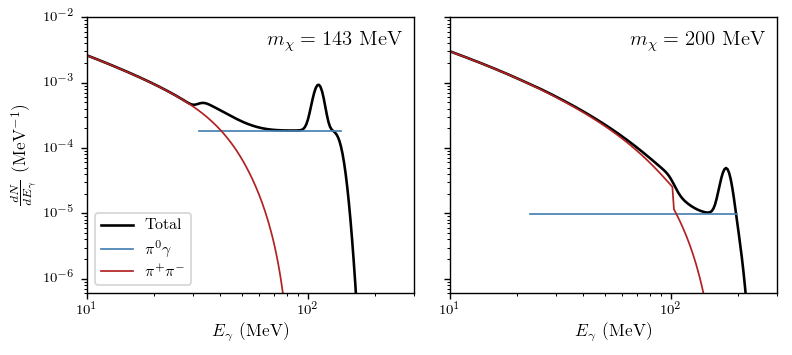

In [294]:
plt.figure(figsize=(6.5, 3))

# Iterate over the values, row and column indices of mxs
it = np.nditer(mxs, flags=['multi_index'])

while not it.finished:
    vm.mx = it[0]  # current value of mx
    idx = it.iterindex  # current index in mxs
    row_idx, col_idx = it.multi_index  # current row and column indices
    
    # Center of mass energy, set to slightly above threshold
    e_cm = 2.*vm.mx * (1. + 0.5 * vx_mw)
    # Compute the spectra!
    spectra = vm.spectra(e_gams, e_cm)
    
    # Switch subplots; plot the spectra for final states containing hadrons
    plt.subplot(n_subplot_rows, n_subplot_cols, idx + 1)
    
    for fs, spec in reversed(sorted(spectra.iteritems())):
        if fs not in ["e e", "mu mu", "total"]:
            plt.loglog(e_gams, spec, label=get_tex_label(fs), linewidth=1)
        if fs == "total":
            dnde_det = get_detected_spectrum(e_gams, spec,
                                             *vm.gamma_ray_lines(e_cm),
                                             energy_res=energy_res_comptel)
            plt.loglog(e_gams, dnde_det(e_gams), "black", label="Total")
            
    ### Formatting
    # Set axis limits
    plt.xlim(10, 300)
    plt.ylim(6e-7, 1e-2)
    
    # Only draw the legend for the first subplot
    if idx == 0:
        plt.legend(loc="lower left")
        
    # Only show ticks and axis labels for subplots on the left and bottom
    if row_idx != n_subplot_rows - 1:
        plt.tick_params(labelbottom="off")
    else:
        plt.xlabel(r"$E_\gamma$ (MeV)")
    if col_idx % n_subplot_cols != 0:
        plt.tick_params(labelleft="off")
    else:
        plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
        
    # Label subplot with dark matter mass
    plt.text(6.5e1, 3.3e-3, r"$m_\chi = %0.f$ MeV" % vm.mx)
    
    it.iternext()

plt.tight_layout()  # remove some of the space between plots

plt.savefig("figures/vector_spectra.pdf")

# Scalar mediator

This import loads the scalar mediator class from hazma.

In [295]:
from hazma.scalar_mediator import ScalarMediator

## Spectra's dependence on $m_\chi$
This section examines the dependence of the vector theory's spectra on the dark matter mass. Changing the couplings is less interesting. For example, setting $g_{Sff} = 0$ turns off the lepton final states without changing the shape of the spectra.

Create a `ScalarMediator` object. The values of couplings to leptons and the strange quark and well as $m_S$ are irrelevant to our focus. The initial value of $m_\chi$ does not matter since it will shortly be changed. The velocity dispersion in the Milky Way $v_\chi \sim 10^{-3}$ is defined here, as it was above.

In [300]:
sm_args = {"mx": 250., "ms": 1000., "gsxx": 1., "gsff": 1., "gsGG": 1., "gsFF": 1.}
sm = ScalarMediator(**sm_args)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

Choose any array of photon energies from 10 - 250 MeV.

In [301]:
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250

e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

Create a 2D array of dark matter masses.

In [302]:
n_subplot_rows, n_subplot_cols = 2, 2

mxs = np.array([100., 110., 140., 250.]).reshape((n_subplot_rows, n_subplot_cols))

Iterate over the array of dark matter masses, computing the spectrum at each $E_\gamma \in$ `e_gams`. Most of the code below formats the plot nicely; the `spectra()` function is called in line 12.

In [ ]:
plt.figure(figsize=(6.5, 5))

# Iterate over the values, row and column indices of mxs
it = np.nditer(mxs, flags=['multi_index'])

while not it.finished:
    sm.mx = it[0]  # current value of mx
    idx = it.iterindex  # current index in mxs
    row_idx, col_idx = it.multi_index  # current row and column indices
    
    # Center of mass energy, set to slightly above threshold
    e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw)
    # Compute the spectra!
    spectra = sm.spectra(e_gams, e_cm)
    # Get line energies and branching fractions
    line_es, line_bfs = sm.gamma_ray_lines(e_cm)
    
    # Switch subplots; plot the spectra for final states containing hadrons
    plt.subplot(n_subplot_rows, n_subplot_cols, idx + 1)
    
    for fs, spec in reversed(sorted(spectra.iteritems())):
        if fs != "total":
            plt.loglog(e_gams, spec, label=get_tex_label(fs), linewidth=1)
        else:
            dnde_det = get_detected_spectrum(e_gams, spec, line_es, line_bfs, energy_res=energy_res_comptel)
            plt.loglog(e_gams, dnde_det(e_gams), "black", label="Total")

    ### Formatting
    # Set axis limits
    plt.xlim(10, 300)
    plt.ylim(1e-5, 1e-1)
    
    # Only draw the legend for the first subplot
    if idx == 1:
        plt.legend(loc="lower right")
        
    # Only show ticks and axis labels for subplots on the left and bottom
    if row_idx != n_subplot_rows - 1:
        plt.tick_params(labelbottom="off")
    else:
        plt.xlabel(r"$E_\gamma$ (MeV)")
    if col_idx % n_subplot_cols != 0:
        plt.tick_params(labelleft="off")
    else:
        plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
        
    # Label subplot with dark matter mass
    plt.text(6.5e1, 3.3e-2, r"$m_\chi = %0.f$ MeV" % sm.mx)
    
    it.iternext()

plt.tight_layout()  # remove some of the space between plots

plt.savefig("figures/scalar_spectra_higgs_portal.pdf")